In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [18]:
import jax.random as random
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

In [19]:
key = random.key(69)
key, key1, key2, key3, key4 = random.split(key, 5)

In [20]:
N = 100
p = 6

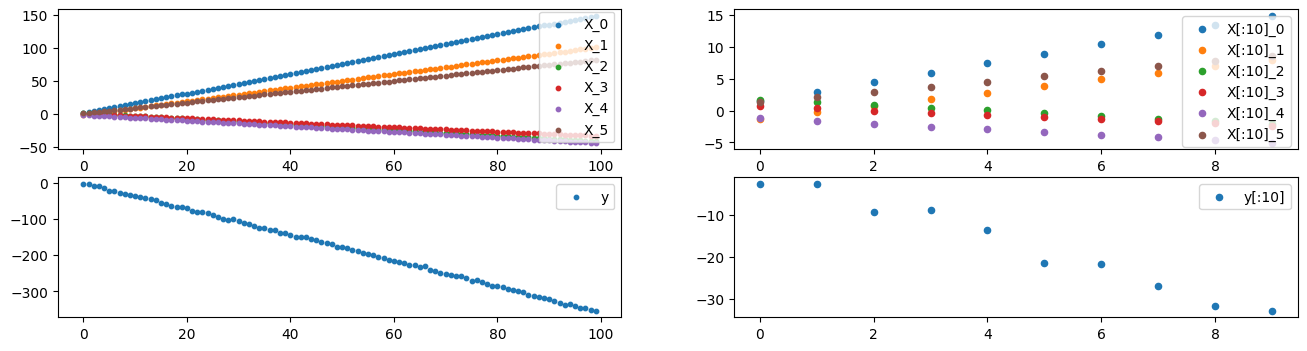

In [21]:
arange = jnp.arange(0, N)
slopes = random.normal(key1, p)
biases = random.normal(key2, p)
B_real = random.normal(key3, p)
X = jnp.broadcast_to(biases, (N, p)) + jnp.broadcast_to(slopes, (N, p))*arange.reshape(N, 1)
y_ideal = jnp.inner(X, B_real)
# y real
y = y_ideal + 2*random.normal(key4, N)
fig,ax = plt.subplots(2, 2, figsize=(16,4))
for k in range(p):
    ax[0, 0].scatter(jnp.arange(N), X[:, k], s=10, label=f'X_{k}')
    ax[0, 1].scatter(jnp.arange(10), X[:10, k], s=20, label=f'X[:10]_{k}')
ax[1, 0].scatter(jnp.arange(N), y[:], s=10, label='y')
ax[1, 1].scatter(jnp.arange(10), y[:10], s=20, label='y[:10]')

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

fig.show()


## Just random function

In [22]:
key, key1 = random.split(key)
B0 = 0
B = random.normal(key1, p)

In [23]:
f = B0 + jnp.dot(X, B)

In [24]:
residue = (y - f)**2

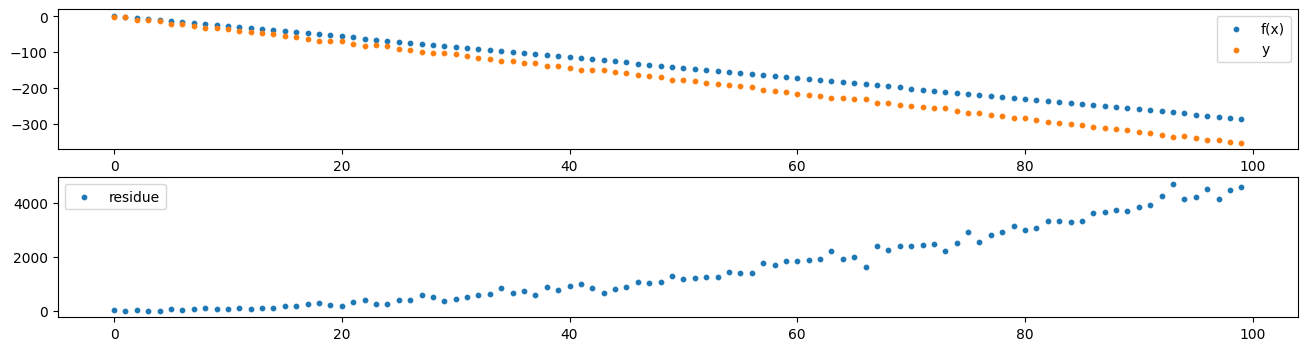

In [25]:
fig,ax = plt.subplots(2, 1, figsize=(16,4))
ax[0].scatter(jnp.arange(N), f[:], s=10, label='f(x)')
ax[0].scatter(jnp.arange(N), y[:], s=10, label='y')
ax[1].scatter(jnp.arange(N), residue[:], s=10, label='residue')
ax[0].legend()
ax[1].legend()

In [26]:
RSS = jnp.sum(residue)
RSS

Array(160534.75, dtype=float32)

## Closed form solution

In [27]:
dRSS_dB = - 2*jnp.dot(X.T, y - f)
dRSS_dB

Array([ 694085.75,  464849.1 , -184506.7 , -150399.27, -204059.55,
        383441.03], dtype=float32)

We want to minimize $RSS$, which is defined as:

$$
RSS(\beta) = \sum_i^N{(y_i - x_i^T\beta)^2}
$$

We get:
$$
RSS(\beta) = (y - X\beta)^T(y - X\beta) =
$$
$$
= y^T y - y^T X\beta - \beta^T X^T y + \beta^T X^T X \beta =
$$
$$
= y^T y - 2 \beta^T X^T y + \beta^T X^T X \beta
$$

Then to get minimum, we want to calculate zero of derivative:

$$
\frac{\partial RSS}{\partial \beta} = -2X^Ty + 2X^TX\beta = -2X^T(y - X\beta)
$$

We're trying to solve for $\frac{\partial RSS}{\partial \beta} = 0$:
$$
0 = -2X^T(y - X\hat{\beta})
$$

$$
0 = X^Ty - X^TX\hat{\beta}
$$

$$
X^TX\hat{\beta} = X^Ty
$$

And we want to solve for $\hat{\beta}$.  
linalg.solve solves for $x$ in $Ax = b$:
```
x = jnp.linalg.solve(A, b)
```
In my case $A=X^TX$, $x=\hat{\beta}$ and $b=X^Ty$:
```
B_hat = jnp.linalg.solve(jnp.dot(X.T, X), jnp.dot(X.T, y))
```

The more straight-forward computation would be:
$$
\hat{\beta} = (X^TX)^{-1}X^Ty
$$
using:
```
B_hat = jnp.dot(jnp.linalg.inv(jnp.dot(X.T, X)), jnp.dot(X.T, y))
```
but python calculates that numerically, step by step which yields massive, massive floating-point errors.

In [28]:
B_hat = jnp.linalg.solve(jnp.dot(X.T, X), jnp.dot(X.T, y))
B_hat

Array([-1.4360591 ,  2.3503544 ,  3.1998675 ,  2.5690906 ,  0.43017566,
       -1.7485434 ], dtype=float32)

In [29]:
f_hat = B0 + jnp.dot(X, B_hat)

In [30]:
residue_hat = (y - f_hat)**2

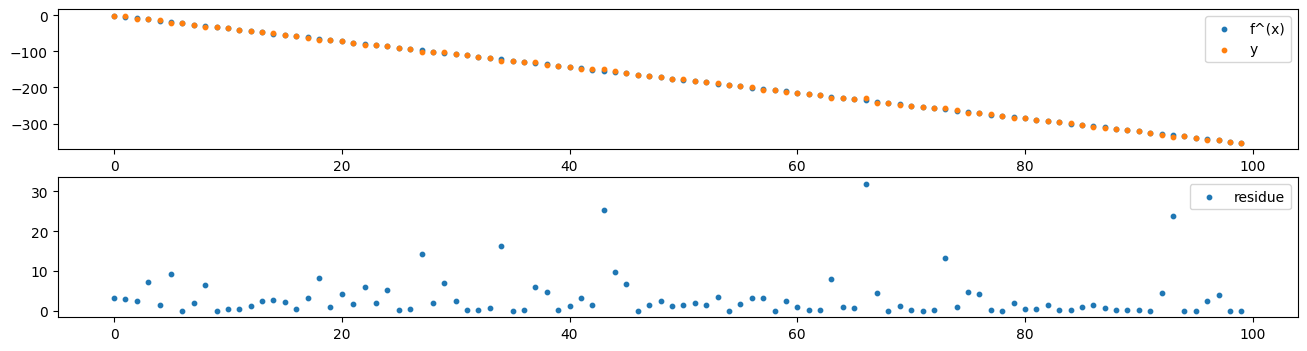

In [31]:
fig,ax = plt.subplots(2, 1, figsize=(16,4))
ax[0].scatter(jnp.arange(N), f_hat[:], s=10, label='f^(x)')
ax[0].scatter(jnp.arange(N), y[:], s=10, label='y')
ax[1].scatter(jnp.arange(N), residue_hat[:], s=10, label='residue')
ax[0].legend()
ax[1].legend()

In [32]:
RSS_hat = jnp.sum(residue_hat)
RSS_hat

Array(320.70258, dtype=float32)